# Website Defacement Detection

* Prepare by **vomtung@gmail.com**

In [1]:
# Install required packages including gensim for Word2Vec
%pip install pandas numpy scikit-learn matplotlib seaborn gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Install Required Packages

First, we need to install the necessary Python packages for our machine learning pipeline.

In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Import Required Libraries

We need several libraries for this document classification task:
- **pandas**: Data manipulation and analysis
- **numpy**: Numerical computing
- **sklearn**: Machine learning tools (TF-IDF, Logistic Regression, metrics)
- **matplotlib & seaborn**: Data visualization

In [3]:
train_df = pd.read_csv('dataset/train_data.csv')
test_df = pd.read_csv('dataset/test_data.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nTraining data columns: {train_df.columns.tolist()}")
print(f"\nLabel distribution in training data:")
print(train_df['Label'].value_counts())
print(f"\nSample data:")
print(train_df.head())

Training data shape: (1230, 2)
Test data shape: (307, 2)

Training data columns: ['HTML', 'Label']

Label distribution in training data:
Label
1    645
0    585
Name: count, dtype: int64

Sample data:
                                                HTML  Label
0  Vimeo Interactive Video Experience Platform   ...      0
1  \nHacked By Shield Iran ! \nHacked By \nShield...      1
2  HACKED BY INDIAN CYBER FORCE \nYOU GOT HACKED ...      1
3  Space.com: NASA, Space Exploration and Astrono...      0
4  Home \r\nYou may be trying to access this site...      0


## Load and Explore Dataset

The dataset contains website HTML content with labels:
- **Label 0**: Normal website
- **Label 1**: Hacked/Defaced website

We have separate training and test datasets to evaluate model performance properly.

## Word2Vec Embedding

**Word2Vec** learns vector representations for words from the HTML content.

### Steps:
- Tokenize HTML text into words
- Train Word2Vec model on all training documents
- Represent each document by averaging its word vectors

This produces a fixed-size vector for each document, suitable for SVM classification.

In [4]:
from gensim.utils import simple_preprocess

# Tokenize HTML content
X_train_raw = train_df['HTML'].fillna('')
X_test_raw = test_df['HTML'].fillna('')

X_train_tokens = [simple_preprocess(doc) for doc in X_train_raw]
X_test_tokens = [simple_preprocess(doc) for doc in X_test_raw]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=2, workers=4, seed=42)

def document_vector(tokens, model):
    # Average word vectors for tokens present in the model's vocabulary
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

X_train_vec = np.array([document_vector(tokens, w2v_model) for tokens in X_train_tokens])
X_test_vec = np.array([document_vector(tokens, w2v_model) for tokens in X_test_tokens])

y_train = train_df['Label']
y_test = test_df['Label']

print(f"Word2Vec train shape: {X_train_vec.shape}")
print(f"Word2Vec test shape: {X_test_vec.shape}")

Word2Vec train shape: (1230, 100)
Word2Vec test shape: (307, 100)


## SVM Model Training

**Support Vector Machine (SVM)** is a powerful classifier for binary tasks.

### Parameters:
- **kernel='linear'**: Linear decision boundary
- **C=1.0**: Regularization strength
- **probability=True**: Enable probability estimates

The model learns to distinguish between normal and hacked websites using Word2Vec features.

In [5]:
print("Training SVM model...")

svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_model.fit(X_train_vec, y_train)

y_train_pred = svm_model.predict(X_train_vec)
y_test_pred = svm_model.predict(X_test_vec)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_test_proba = svm_model.predict_proba(X_test_vec)[:, 1]
print(f"Model trained successfully!")

Training SVM model...
Training Accuracy: 0.9976
Test Accuracy: 0.9837
Model trained successfully!


## Model Evaluation and Analysis

### Performance Metrics:
- **Classification Report**: Precision, Recall, F1-score for each class
- **Confusion Matrix**: Visual representation of correct vs incorrect predictions
- **Feature Importance**: Top words/phrases that indicate hacked vs normal websites

### Understanding Results:
- **Precision**: Of all websites predicted as hacked, how many are actually hacked?
- **Recall**: Of all actually hacked websites, how many did we detect?
- **F1-score**: Harmonic mean of precision and recall

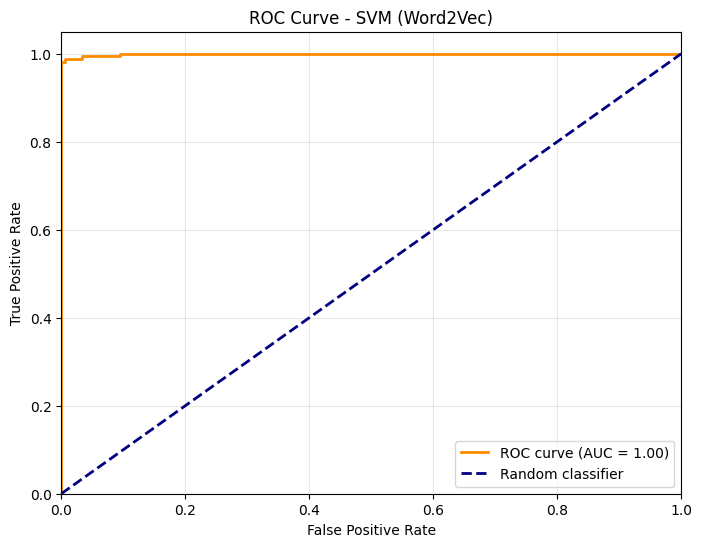

ROC AUC Score: 0.9991
Optimal threshold: 0.1674
At optimal threshold - TPR: 0.9812, FPR: 0.0000

=== THRESHOLD ANALYSIS ===
Threshold 0.300: Precision=1.000, Recall=0.969, F1=0.984
Threshold 0.500: Precision=1.000, Recall=0.963, F1=0.981
Threshold 0.700: Precision=1.000, Recall=0.956, F1=0.978
Threshold 0.167: Precision=1.000, Recall=0.981, F1=0.991


In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM (Word2Vec)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

# Find optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At optimal threshold - TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

# Additional metrics at different thresholds
print("\n=== THRESHOLD ANALYSIS ===")
thresholds_to_check = [0.3, 0.5, 0.7, optimal_threshold]
for threshold in thresholds_to_check:
    y_pred_threshold = (y_test_proba >= threshold).astype(int)
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    
    print(f"Threshold {threshold:.3f}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98       147
      Hacked       1.00      0.97      0.98       160

    accuracy                           0.98       307
   macro avg       0.98      0.98      0.98       307
weighted avg       0.98      0.98      0.98       307



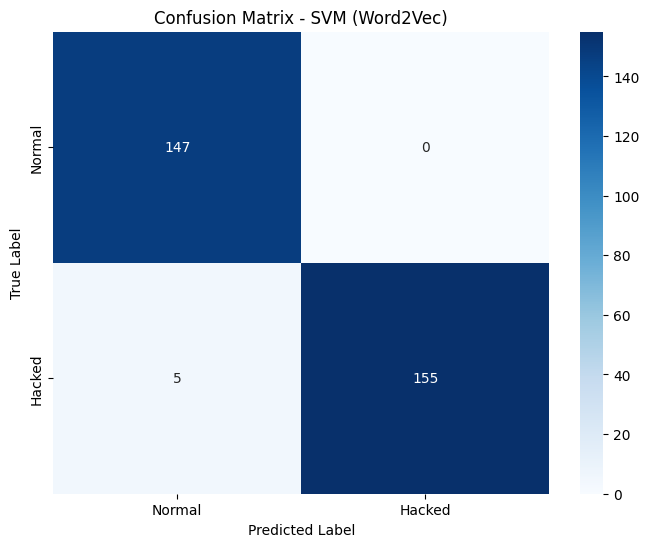

In [7]:
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Hacked']))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Hacked'],
            yticklabels=['Normal', 'Hacked'])
plt.title('Confusion Matrix - SVM (Word2Vec)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Testing with New Samples

This section demonstrates how to use the trained SVM model with Word2Vec to classify new website content.

### The `predict_website()` function:
1. **Input**: Raw HTML content as text
2. **Transform**: Tokenize and average Word2Vec vectors
3. **Predict**: Use SVM to classify as Normal/Hacked
4. **Output**: Classification result with confidence percentage

We test with sample texts including both normal website content and typical hacker messages.

In [8]:
def predict_website(html_content):
    """Predict if a website is hacked or normal using SVM + Word2Vec"""
    tokens = simple_preprocess(html_content)
    vec = document_vector(tokens, w2v_model).reshape(1, -1)
    prediction = svm_model.predict(vec)[0]
    probability = svm_model.predict_proba(vec)[0]
    result = "Hacked" if prediction == 1 else "Normal"
    confidence = probability[prediction] * 100
    return result, confidence

test_samples = [
    "Welcome to our website! We offer great products and services.",
    "HACKED BY ANONYMOUS! Your site has been compromised!",
    "Contact us for more information about our company.",
    "Hacked By Shield Iran! We Are N3TC4t - Nazila Blackhat"
]

print("=== TESTING WITH NEW SAMPLES ===")
for i, sample in enumerate(test_samples, 1):
    result, confidence = predict_website(sample)
    print(f"Sample {i}: {result} (Confidence: {confidence:.2f}%)")
    print(f"Text: {sample[:100]}...")
    print("-" * 50)

=== TESTING WITH NEW SAMPLES ===
Sample 1: Normal (Confidence: 97.19%)
Text: Welcome to our website! We offer great products and services....
--------------------------------------------------
Sample 2: Hacked (Confidence: 100.00%)
Text: HACKED BY ANONYMOUS! Your site has been compromised!...
--------------------------------------------------
Sample 3: Normal (Confidence: 100.00%)
Text: Contact us for more information about our company....
--------------------------------------------------
Sample 4: Hacked (Confidence: 100.00%)
Text: Hacked By Shield Iran! We Are N3TC4t - Nazila Blackhat...
--------------------------------------------------


In [ ]:
# Export trained model and Word2Vec for Django application
import pickle

with open('svm_word2vec_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

with open('svm_word2vec_vectorizer.pkl', 'wb') as f:
    pickle.dump(w2v_model, f)

print("Model and Word2Vec Vectorizer exported as 'svm_word2vec_model.pkl' and 'svm_word2vec_vectorizer.pkl'.")

NameError: name 'tfidf_vectorizer' is not defined